# Creating a cross section through a RHI scan

In field campaigns with radar systems performing vertical, range-height indicator scans, we can visualize a cross section of LMA points along the plane of the RHI.

In [1]:
import glob
import datetime as dt

from pyxlma import coords
from pyxlma.lmalib import lma_intercept_rhi
from pyxlma.lmalib.io import read as lma_read
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats, filter_flashes

from cartopy import crs as ccrs
from cartopy import feature as cfeat
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
# Read in our data
filenames = glob.glob('./LYLOUT_221120_0[8-9]*_0600.dat.gz')
filenames += glob.glob('./LYLOUT_221120_1[0-1]*_0600.dat.gz')
filenames.sort()
lma_data, start_time = lma_read.dataset(filenames)

# Filter events
min_event_stations = 7
max_event_chi2 = 1
good_events = (lma_data.event_stations >= min_event_stations) & (lma_data.event_chi2 <= max_event_chi2)
lma_data = lma_data[{'number_of_events':good_events}]

# Cluster flashes and calculate stats
lma_data = flash_stats(cluster_flashes(lma_data))
# Filter Flashes
min_points_per_flash = 5
big_flash_data = filter_flashes(lma_data, flash_event_count=(min_points_per_flash, None))
big_flash_data

<xarray.Dataset> Size: 1MB
Dimensions:                              (number_of_stations: 16,
                                          number_of_events: 12225,
                                          number_of_flashes: 97)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 776B 1 .....
Dimensions without coordinates: number_of_stations, number_of_events
Data variables: (12/42)
    network_center_latitude              float64 8B 43.59
    network_center_longitude             float64 8B -75.72
    network_center_altitude              float64 8B 220.8
    station_latitude                     (number_of_stations) float32 64B 43....
    station_longitude                    (number_of_stations) float32 64B -75...
    station_altitude                     (number_of_stations) float32 64B 358...
    ...                                   ...
    flash_event_count                    (number_of_flashes) uint32 388B 199 ...
    event_parent_flash_id                (number_of_events) uint64 98kB 1 ......
    event_x                              (number_of_events) float64 98kB -692...
    event_y                              (number_of_events) float64 98kB 3.07...
    event_z                              (number_of_events) float32 49kB 2.65...
    flash_id                             (number_of_flashes) uint64 776B 1 .....
Attributes:
    institution:              unknown
    comment:                  
    source:                   VHF Lightning Mapping Array
    history:                  LMA source file created  Wed Jan  4 17:36:30 20...
    production_site:          Default
    production_date:          2024-08-07 22:00:59 +00:00
    flash_algorithm_name:     pyxlma DBSCAN
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_version:   10.14.5R
    flash_algorithm_version:  0.1
    event_algorithm_name:      ./lma_analysis -d 20221120 -t 080000 -s 600 -l...
    references:

interactive(children=(IntSlider(value=39, description='big_flash', max=96), Output()), _dom_classes=('widget-i…

<function __main__.plot(big_flash=0)>

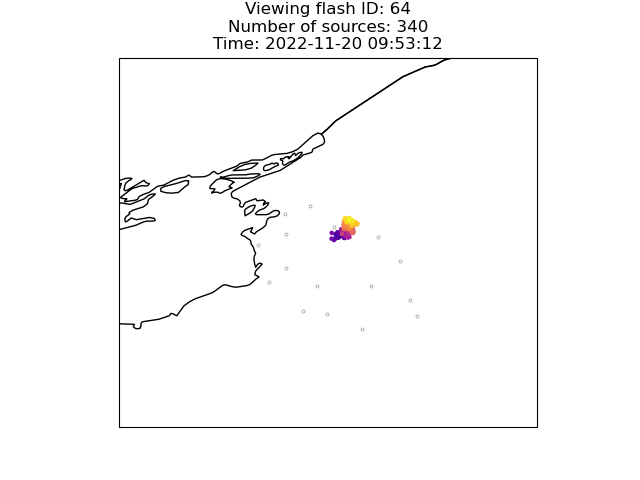

In [3]:
fig = plt.figure()

def plot(big_flash=0):
    fig.clear()
    ax = plt.axes(projection=ccrs.PlateCarree())
    this_flash = big_flash_data.isel(number_of_flashes=big_flash)
    flash_id = this_flash.flash_id.data.item()
    events_in_flash = (this_flash.event_parent_flash_id == flash_id)
    this_flash = this_flash[{'number_of_events':events_in_flash}]
    ax.scatter(this_flash.event_longitude, this_flash.event_latitude, s=5, c=this_flash.event_time, cmap='plasma')
    ax.scatter(this_flash.station_longitude, this_flash.station_latitude, s=5, c='white', edgecolor='k', linewidths=0.2)
    ax.add_feature(cfeat.STATES)
    ax.set_extent([big_flash_data.event_longitude.data.min()-1, big_flash_data.event_longitude.data.max()+1,
                   big_flash_data.event_latitude.data.min()-1, big_flash_data.event_latitude.data.max()+1])
    ax.set_title(f'Viewing flash ID: {flash_id}\nNumber of sources: {this_flash.flash_event_count.data.item()}'
                    f'\nTime: {this_flash.flash_time_start.data.astype("datetime64[s]").item()}')

interact(plot, big_flash=widgets.IntSlider(min=0, max=big_flash_data.flash_id.shape[0]-1, step=1, value=39))

After scrolling around for a few minutes, I think I want to visualize flash ID #64. Let's download some radar data at around the same time as the flash from the nearest NEXRAD site, KTYX. If you have radar data that can be loaded in using pyart, you can skip this step and change the radar_file_path below.

In [4]:
flash_i_want = 64
this_flash = lma_data.sel(number_of_flashes=flash_i_want)
events_in_flash = (this_flash.event_parent_flash_id == flash_i_want)
this_flash = this_flash[{'number_of_events':events_in_flash}]
flash_time = this_flash.flash_time_start.data.astype('datetime64[s]').astype(dt.datetime)

In [5]:
import nexradaws
conn = nexradaws.NexradAwsInterface()
radar_id = 'KTYX'

range_start = flash_time - dt.timedelta(minutes=5)
range_end = flash_time + dt.timedelta(minutes=5)

scans = conn.get_avail_scans_in_range(range_start, range_end, radar_id)
print(scans)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

[<AwsNexradFile object - 2022/11/20/KTYX/KTYX20221120_095249_V06>]


The radar scan closest to our flash took place at 10:11:06 UTC. Download that one.

In [6]:
radar_download = conn.download(scans[-1], '.')

Downloaded KTYX20221120_095249_V06
1 out of 1 files downloaded...0 errors


In [7]:
import pyart
import cmweather
radar_file_path = radar_download.success[0].filepath # try changing this to a string with the path to your own data!
radar = pyart.io.read(radar_file_path)
print(list(radar.fields.keys()))

['reflectivity', 'clutter_filter_power_removed', 'differential_phase', 'cross_correlation_ratio', 'differential_reflectivity', 'spectrum_width', 'velocity']


Now, create a map of the reflectivity with the LMA points!

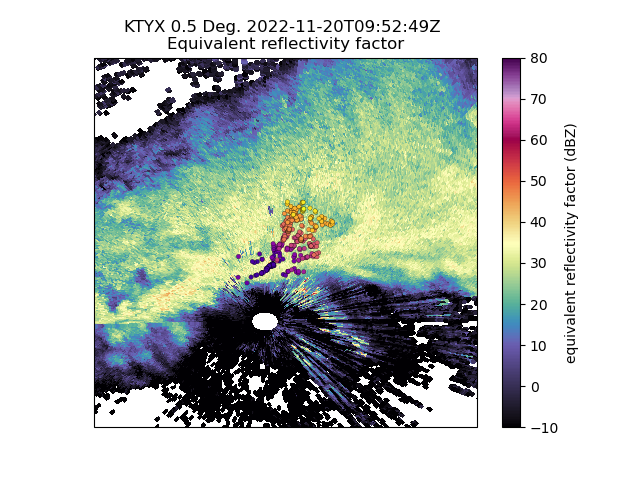

In [8]:
field_i_want = 'reflectivity'
radar_fig = plt.figure()
radar_ax = plt.axes(projection=ccrs.PlateCarree())

rmd = pyart.graph.RadarMapDisplay(radar)
rmd.plot_ppi_map(field_i_want, vmin=-10, vmax=80, cmap='ChaseSpectral', ax=radar_ax, fig=radar_fig, add_grid_lines=False)

radar_ax.scatter(this_flash.event_longitude, this_flash.event_latitude, c=this_flash.event_time, cmap='plasma', s=10, edgecolor='k', linewidths=0.2, transform=ccrs.PlateCarree())
radar_ax.set_extent([this_flash.event_longitude.data.min()-0.25, this_flash.event_longitude.data.max()+0.25,
                   this_flash.event_latitude.data.min()-0.25, this_flash.event_latitude.data.max()+0.25])

Using the flash_center variables, find the azimuth of the flash from the perspective of the radar to build a psuedo-RHI from

In [9]:
radar_lon = radar.longitude['data'][0]
radar_lat = radar.latitude['data'][0]
radar_alt = radar.altitude['data'][0]
radar_time = pyart.util.datetime_from_radar(radar)

plate_carree_projection = coords.GeographicSystem()
radar_coords = coords.RadarCoordinateSystem(radar_lat, radar_lon, radar_alt)

this_flash.flash_center_longitude.data, this_flash.flash_center_latitude.data, this_flash.flash_center_altitude.data
flash_range, flash_azimuth, flash_elevation = radar_coords.fromECEF(*plate_carree_projection.toECEF(this_flash.flash_center_longitude.data, this_flash.flash_center_latitude.data, this_flash.flash_center_altitude.data))
flash_range = flash_range[0]
flash_azimuth = flash_azimuth[0]
flash_elevation = flash_elevation[0]
print(f'Flash center is located at azimuth {flash_azimuth:.1f}°, elevation of {flash_elevation:.1f}°, and range of {flash_range:.1f}m')

Flash center is located at azimuth 13.2°, elevation of 10.3°, and range of 15925.3m


Make an RHI plot of the nearest azimuth to the flash centroid

(0.0, 10.0)

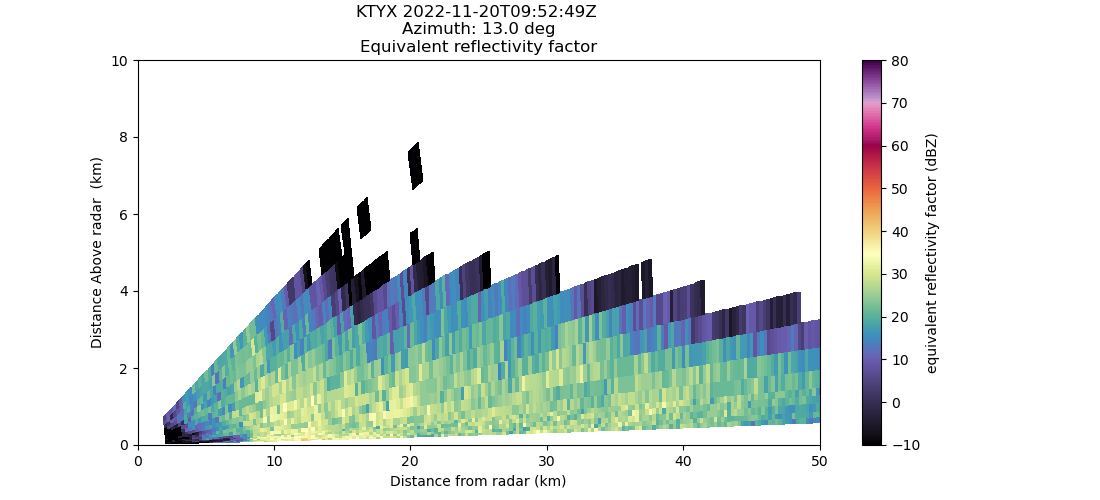

In [10]:
rhi_fig = plt.figure(figsize=(11, 5))
rhi_ax = rhi_fig.gca()
rmd.plot_azimuth_to_rhi(field_i_want, int(flash_azimuth), vmin=-10, vmax=80, cmap='ChaseSpectral', ax=rhi_ax, fig=rhi_fig)
rhi_ax.set_xlim([0, 50])
rhi_ax.set_ylim([0, 10])

Transform the LMA points from lat/lon/altitude to range along the RHI plane, distance from the plane, and height above the radar. Add these transformed points to the above figure.

In [11]:
lma_range, lma_distance, lma_ARL, point_mask = lma_intercept_rhi.find_lma_points_near_rhi(this_flash, radar_lat, radar_lon, radar_alt, int(flash_azimuth), radar_time, distance_threshold=99999999, time_threshold=300)
sec_since_flash_start = (this_flash.event_time[point_mask] - this_flash.flash_time_start.data).astype(float)/1e9
pcm = rhi_ax.scatter(lma_range/1000, lma_ARL/1000, c=sec_since_flash_start, cmap='plasma', s=10, edgecolor='k', linewidths=0.2)
rhi_fig.colorbar(pcm, label='Seconds since flash initiation')